In [88]:
from matplotlib.collections import LineCollection
import matplotlib as mpl
from matplotlib.colors import rgb2hex
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
from sklearn.cluster import DBSCAN
from mpl_toolkits.basemap import Basemap

In [ ]:
# using below link to import basemap 
# !pip install https://github.com/matplotlib/basemap/archive/master.zip

In [10]:
from google.colab import files
uploaded = files.upload()

Saving uszips.csv to uszips (1).csv


In [11]:
zips = pd.read_csv("uszips.csv")

In [12]:
zips.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18005,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17113.0,102.7,72001,Adjuntas,"{""72001"": ""99.43"", ""72141"": ""0.57""}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36074,-67.17519,Aguada,PR,Puerto Rico,True,NaN,37751.0,476.0,72003,Aguada,"{""72003"": ""100""}",Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45440,-67.12201,Aguadilla,PR,Puerto Rico,True,NaN,47081.0,574.9,72005,Aguadilla,"{""72005"": ""100""}",Aguadilla,72005,False,False,America/Puerto_Rico
3,606,18.16721,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6392.0,58.3,72093,Maricao,"{""72093"": ""94.88"", ""72153"": ""3.78"", ""72121"": ""...",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29032,-67.12244,Anasco,PR,Puerto Rico,True,NaN,26686.0,286.9,72011,Añasco,"{""72011"": ""99.45"", ""72003"": ""0.55""}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico


In [13]:
zips.shape

(33121, 18)

In [14]:
zips['state_id'].unique()

array(['PR', 'VI', 'MA', 'RI', 'NH', 'ME', 'VT', 'CT', 'NY', 'NJ', 'PA',
       'DE', 'DC', 'VA', 'MD', 'WV', 'NC', 'SC', 'GA', 'FL', 'AL', 'TN',
       'MS', 'KY', 'OH', 'IN', 'MI', 'IA', 'WI', 'MN', 'SD', 'ND', 'MT',
       'IL', 'MO', 'KS', 'NE', 'LA', 'AR', 'OK', 'TX', 'CO', 'WY', 'ID',
       'UT', 'AZ', 'NM', 'NV', 'CA', 'HI', 'AS', 'GU', 'MP', 'OR', 'WA',
       'AK'], dtype=object)

In [15]:
# remove the data of non-continental states (Alaska and Hawaii)

zips.drop(zips[zips['state_id'] == 'AK'].index, inplace=True)
zips.drop(zips[zips['state_id'] == 'HI'].index, inplace=True)

In [16]:
zips['state_id'].unique()

array(['PR', 'VI', 'MA', 'RI', 'NH', 'ME', 'VT', 'CT', 'NY', 'NJ', 'PA',
       'DE', 'DC', 'VA', 'MD', 'WV', 'NC', 'SC', 'GA', 'FL', 'AL', 'TN',
       'MS', 'KY', 'OH', 'IN', 'MI', 'IA', 'WI', 'MN', 'SD', 'ND', 'MT',
       'IL', 'MO', 'KS', 'NE', 'LA', 'AR', 'OK', 'TX', 'CO', 'WY', 'ID',
       'UT', 'AZ', 'NM', 'NV', 'CA', 'AS', 'GU', 'MP', 'OR', 'WA'],
      dtype=object)

In [17]:
# all is (33121, 18)

zips.shape

(32789, 18)

In [18]:
# check missing values in variables

zips.isnull().sum()

zip                     0
lat                     0
lng                     0
city                    0
state_id                0
state_name              0
zcta                    0
parent_zcta         32789
population             24
density                24
county_fips             0
county_name             0
county_weights          0
county_names_all        0
county_fips_all         0
imprecise               0
military                0
timezone                0
dtype: int64

# Data clustering algorithm: DBSCAN (Density-based spatial clustering of applications with noise)

Step:
1. BSCAN requires two parameters: scan radius (EPS) and minimum number of inclusion points (minpts). Select any point that is not visited and find out all nearby points within EPS (including EPS).
2. If the number of nearby points ≥ minpts, the current point and its nearby points become a cluster. Then, the starting point is marked as visited. Then recursively classified in the same way for others unvisited points. 
3. If the number of nearby points < minpts, the point is temporarily marked as a noise point.
4. If the cluster is fully extended, that is, all points in the cluster are marked as visited. Then using the same algorithm to deal with the unreachable points.

In [60]:
# sorted 10 cities by the density of zip code
zips.drop_duplicates(inplace=True)
zipCounts = zips.groupby(['city'], as_index=False).count()
sorted_cities = zipCounts[['city', 'zip']].sort_values(by=['zip'], ascending=False).head(10)
sorted_cities

,city,zip
7099,Houston,105
16246,Washington,75
10758,New York,69
8810,Los Angeles,65
9752,Miami,63
13602,San Antonio,62
7650,Kansas City,61
3642,Dallas,58
2717,Chicago,56
11993,Philadelphia,53


In [36]:
# EPS: searching the smallest city in size on the Internet, and then calculating
# its aproximate radius using Google maps. Picked 0.29

# minpts: the zip counts of 10th city is 53. Picked 52.

zipCoords = zips[['lat', 'lng']]
model = DBSCAN(eps=0.29, min_samples=52)
model.fit(zipCoords)

DBSCAN(algorithm='auto', eps=0.29, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=52, n_jobs=None, p=None)

In [22]:
# The resulting model classify each row to a specific cluster with a label
labels = model.labels_
unique, counts = np.unique(labels, return_counts=True)
# checked the number of clusters automatically created.
len(counts)

45

In [62]:
# saved the first 10 clusters in the dataset, order by descending
clusters = pd.DataFrame({'label':unique[1:], 'counts':counts[1:]})
cities_10 = clusters.sort_values(by=['counts'], ascending=False).head(10)

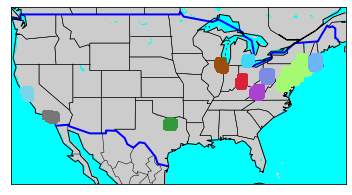

In [85]:
map1 = Basemap(llcrnrlon = -125, 
            llcrnrlat = 23,
            urcrnrlon = -66,
            urcrnrlat = 50,
            projection ='mill',
            resolution = 'c')

map1.drawcountries(color='blue', linewidth=2.0)
map1.drawstates()
map1.drawcoastlines()
map1.drawlsmask(ocean_color="aqua")

# For each cluster in the first 10 cities with most zip codes
# every zip code is ploted with the same color using its map coordinate

for i, cluster_row in cities_10.iterrows():
   rgb = [rd.random(),rd.random(),rd.random()]
   clusteri = zipCoords[labels == cluster_row['label']]
   for j, zip_loc in clusteri.iterrows():
      x, y = map1(zip_loc['lng'], zip_loc['lat'])
      map1.plot(x, y, marker='s',color=rgb)

plt.show()

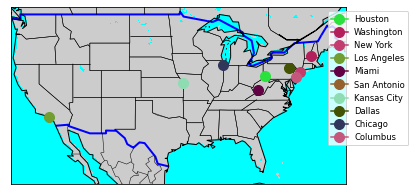

In [87]:
map2 = Basemap(llcrnrlon = -125, 
            llcrnrlat = 23,
            urcrnrlon = -66,
            urcrnrlat = 50,
            projection ='mill',
            resolution = 'c')

map2.drawcountries(color='blue', linewidth=2.0)
map2.drawstates()
map2.drawcoastlines()
map2.drawlsmask(ocean_color="aqua")

# For each group obtaining by grouping the dataset by Cities, pickde the first 
# one occurrence city to represent this city. To compare with the clustering algorithm

for i, cluster_row in sorted_cities.iterrows():
   rgb = [rd.random(), rd.random(), rd.random()]
   clusteri = zips[zips.city == cluster_row['city']]
   reference = clusteri.iloc[0]
   x, y = map2(reference['lng'], reference['lat'])
   map2.plot(x, y, marker='o', markersize=10, label=reference['city'], color=rgb)

fontP = FontProperties()
fontP.set_size('small')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), prop=fontP)
plt.show()

# conclusion
The first city is Houston. The second is washing. The Third is New York, etc.
From the map1 and map2, we can see there are 3 different clusterings. In some case some, two more cities become a clustering. The reasons are that the zipcode is sparse or the distance is too far. 
